messing around with saliency maps

In [28]:
import os
import pickle
import numpy as np
import torch
import torch.nn as nn

from spenderq import load_model
from spenderq import util as U
from spenderq import lyalpha as LyA

In [2]:
from matplotlib import gridspec

In [3]:
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

# load SpenderQ model

In [4]:
models, _ = load_model('/tigress/chhahn/spender_qso/models/qso.edr.hiz.sa1p5sb1p5.i3.pt')

/home/chhahn/projects/SpenderQ/src/spenderq/__init__.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_struct = torch.load(filename, map_location=device)


In [5]:
wave_obs = np.array(models[0].wave_obs)
with open('/tigress/chhahn/spender_qso/train/edr.lfsc.rsnr.sa1p1sb0p8.i3_0.pkl', "rb") as f:    
    spec, w, z, target_id, norm, zerr = pickle.load(f)

In [ ]:
# Saliency map computation
def compute_saliency_map(model, input_data, target_class):
    model.eval()
    input_data.requires_grad_()  # Ensure input has gradients enabled

    output = model(input_data)  # Forward pass
    target_score = output[:, target_class]  # Score of the target class
    target_score.backward(torch.ones_like(target_score))  # Backpropagate

    # Compute the absolute value of the gradients as saliency
    saliency = input_data.grad.abs()
    return saliency

In [23]:
def compute_saliency(_spec, i_latent): 
    models[0].eval()
    _spec.requires_grad_()
    s = models[0].encode(_spec[None,:])
    target_score = s[:,i_latent]
    target_score.backward()
    return _spec.grad.abs() * _spec

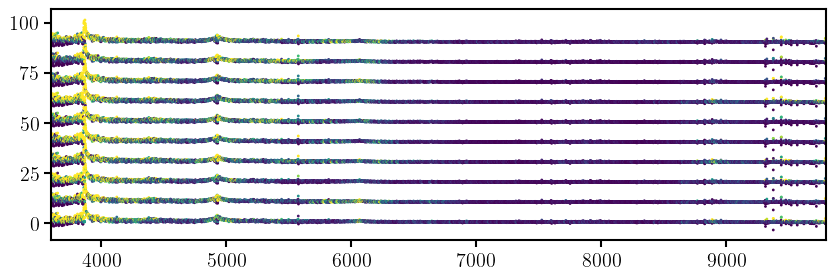

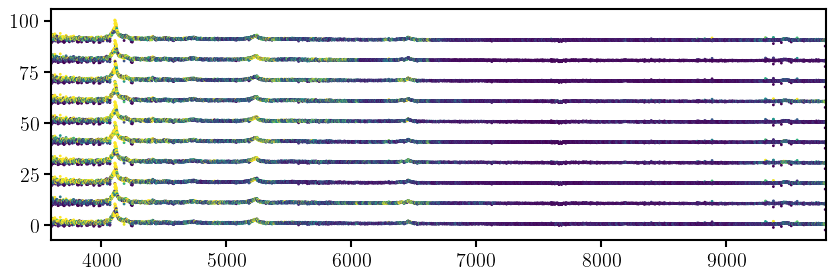

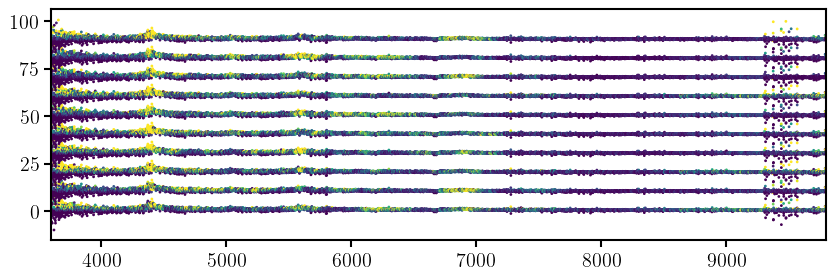

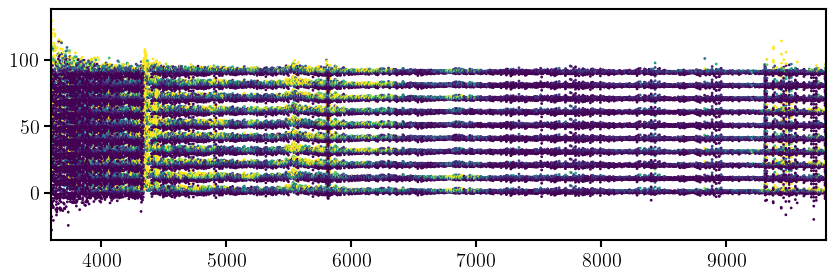

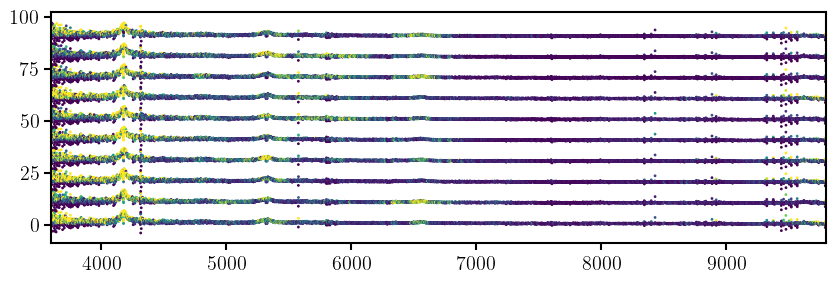

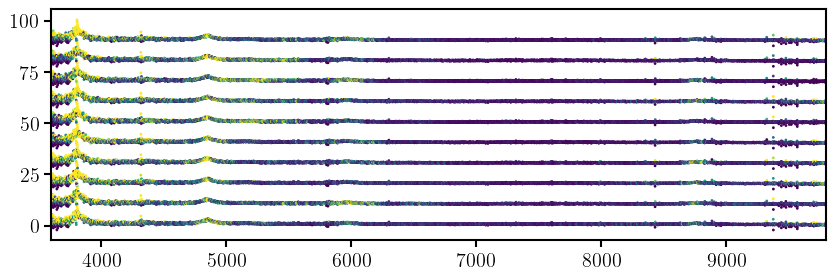

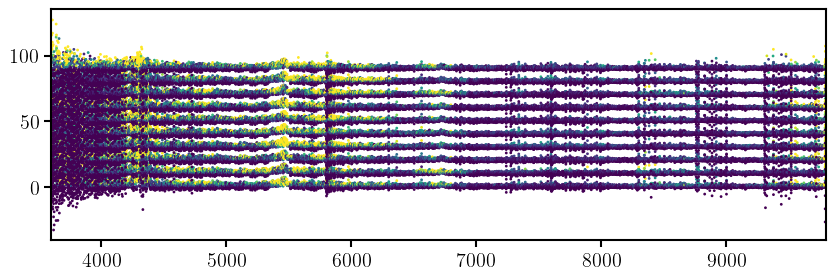

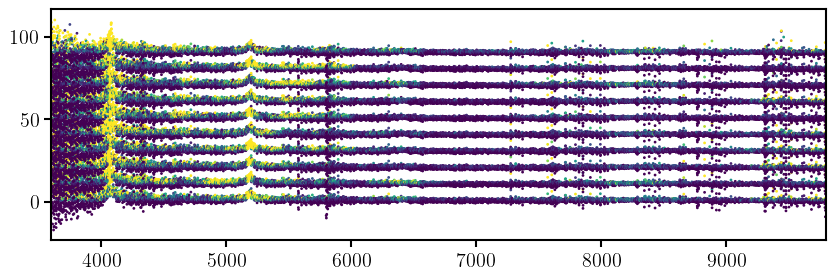

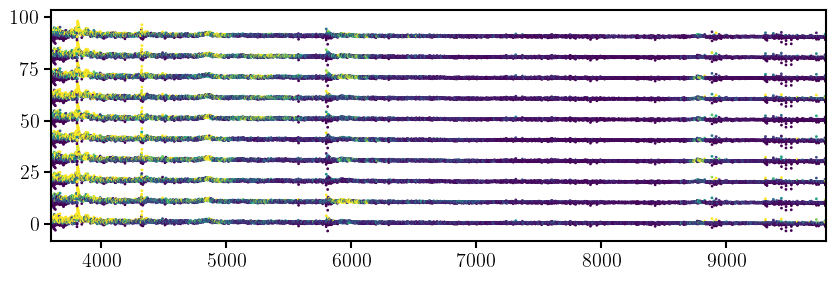

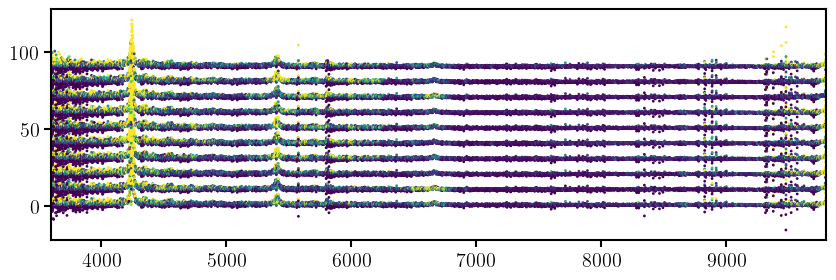

In [25]:
for igal in range(10): 
    
    fig = plt.figure(figsize=(10,3))
    sub = fig.add_subplot(111)
    
    for i in range(10): 
        sal = compute_saliency(spec[igal], i)
        sub.scatter(np.array(models[0].wave_obs), np.array(spec[igal])+i*10, 
                    c=np.array(sal.detach().numpy()), s=1, vmin=0, vmax=np.quantile(sal.detach().numpy(), 0.95))
    sub.set_xlim(3.6e3, 9.8e3)
    plt.show()

In [33]:
# Guided Backpropagation implementation
class GuidedBackprop:
    def __init__(self, model):
        self.model = model
        self.model.eval()
        self.hooks = []

        # Register hooks to modify gradients during backpropagation
        for layer in self.model.children():
            if isinstance(layer, nn.ReLU):
                hook = layer.register_backward_hook(self._backward_hook)
                self.hooks.append(hook)
    
    def _backward_hook(self, module, grad_input, grad_output):
        # Mask negative gradients in the backward pass
        guided_grad_input = torch.clamp(grad_input[0], min=0.0)
        return (guided_grad_input,)

    def compute_saliency(self, input_data, i_latent):
        input_data.requires_grad_()
        s = self.model.encode(input_data)
        
        target_score = s[:,i_latent]
        target_score.backward()
        return input_data.grad.abs()
        #output.sum().backward()  # Backpropagate through all outputs
        #saliency = input_data.grad.abs()  # Absolute value of gradients
        #return saliency

    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()

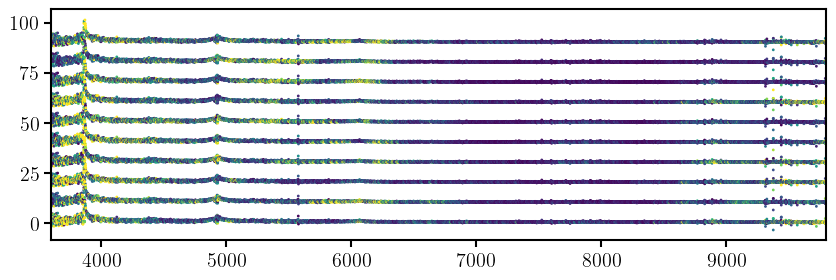

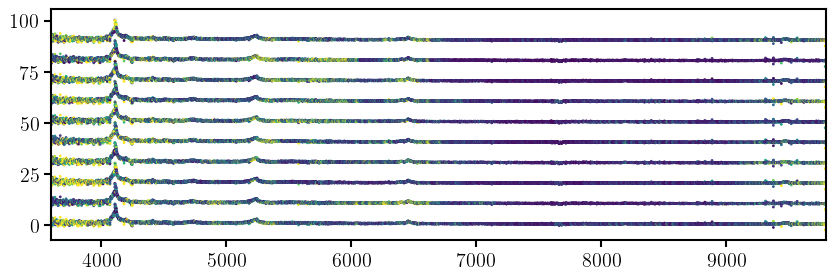

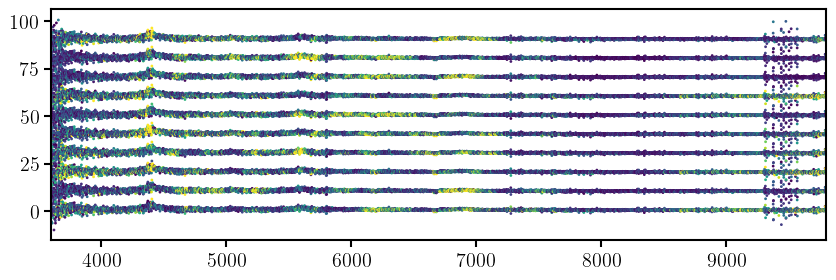

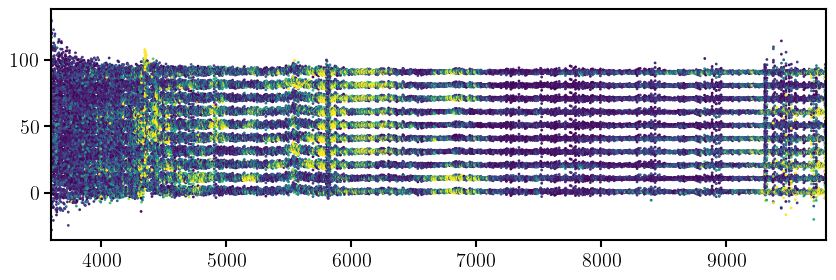

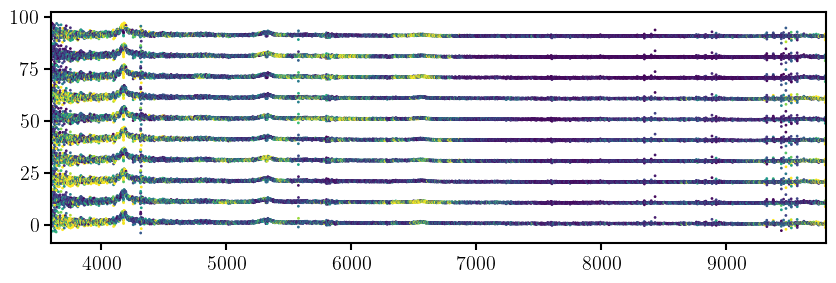

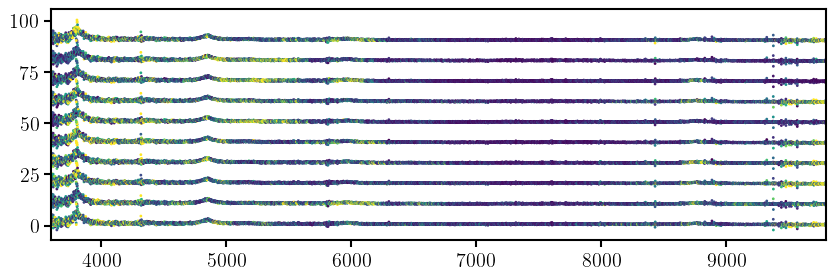

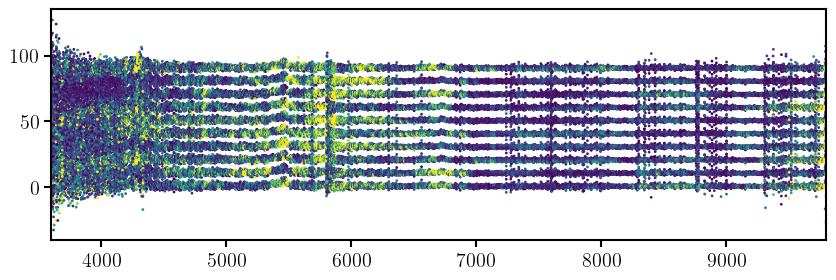

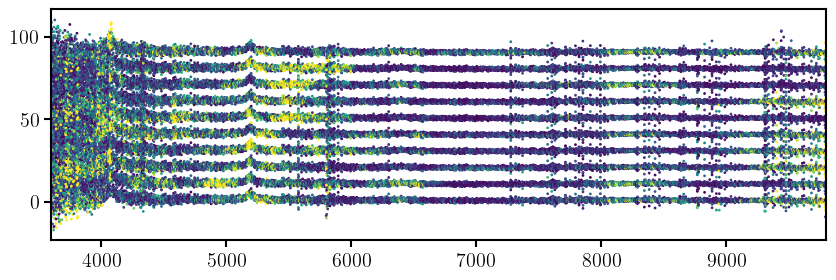

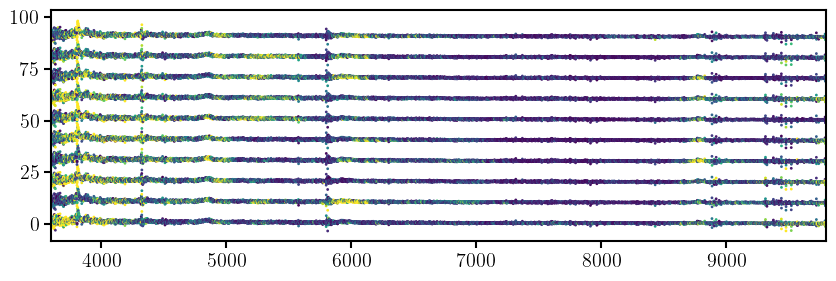

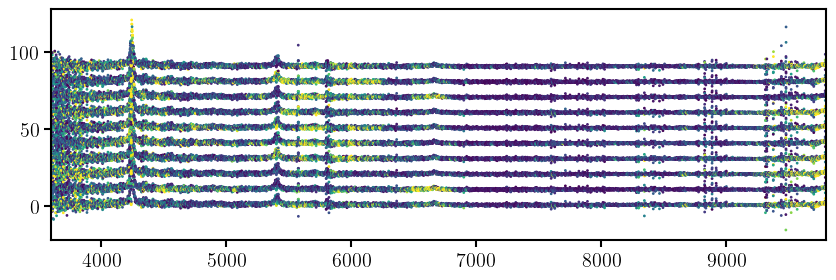

In [35]:
for igal in range(10): 
    
    fig = plt.figure(figsize=(10,3))
    sub = fig.add_subplot(111)
    
    for i in range(10): 
        # Compute Guided Backpropagation saliency map
        guided_bp = GuidedBackprop(models[0])
        sal = guided_bp.compute_saliency(spec[igal][None,:], i)
        # Clean up hooks
        guided_bp.remove_hooks()
        
        sub.scatter(np.array(models[0].wave_obs), np.array(spec[igal])+i*10, 
                    c=np.array(sal.detach().numpy()), s=1, vmin=0, vmax=np.quantile(sal.detach().numpy(), 0.95))
    sub.set_xlim(3.6e3, 9.8e3)
    plt.show()

In [41]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

/tmp/ipykernel_2736018/106273948.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  wave_rebin = np.arange(models[0].wave_obs[0], models[0].wave_obs[-1], 10)[1:-1]


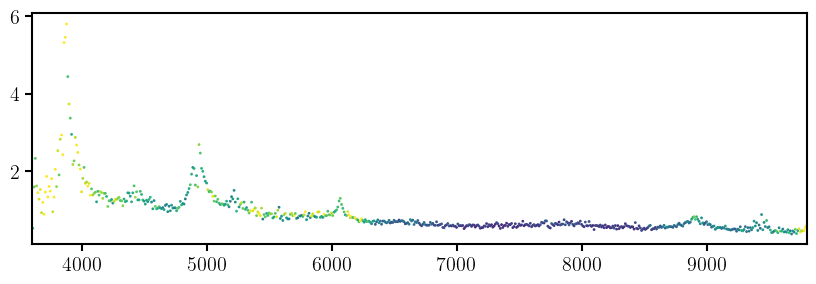

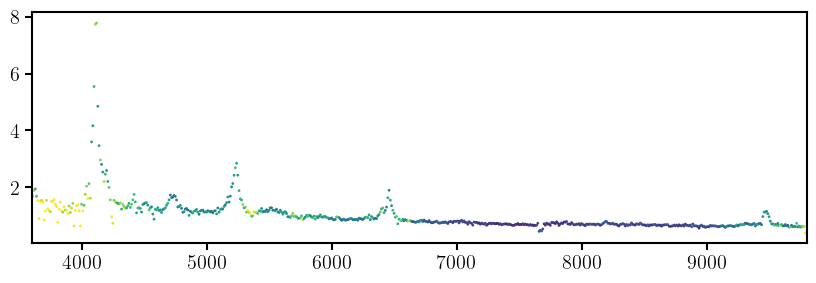

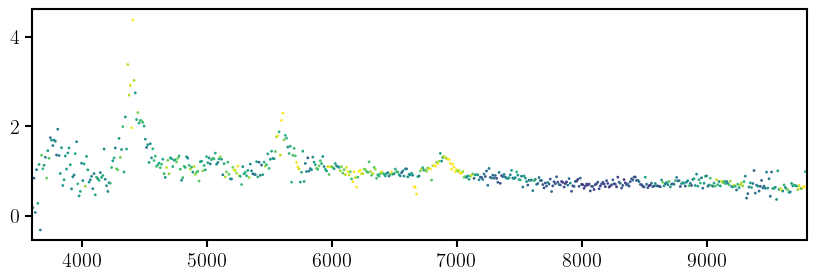

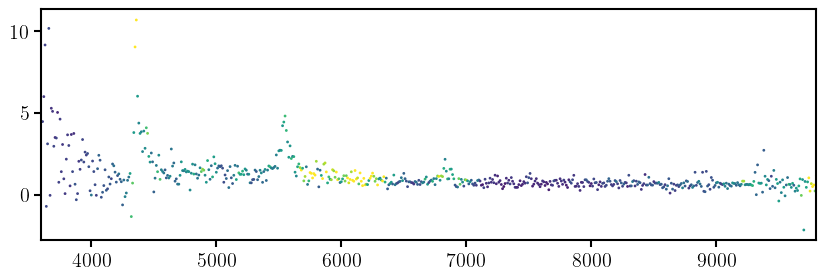

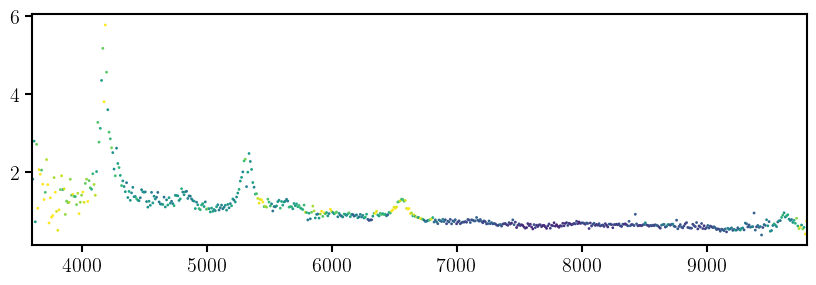

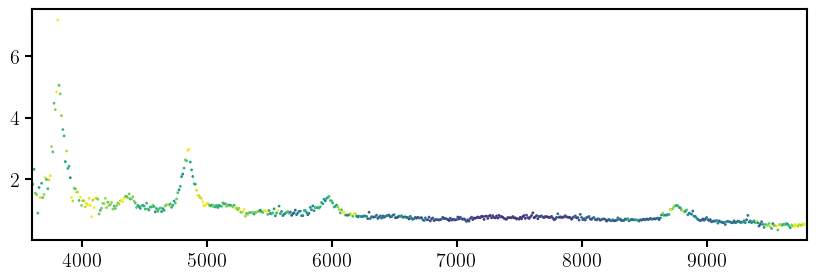

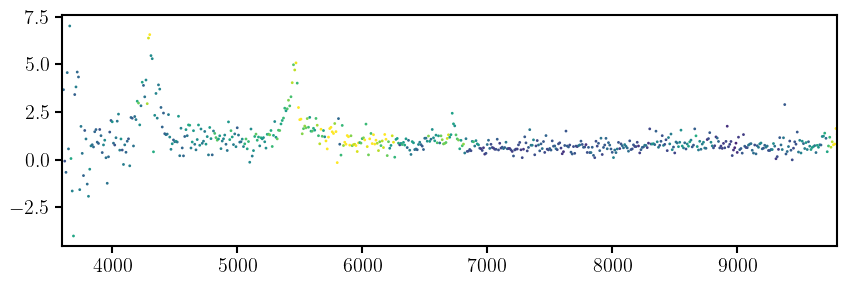

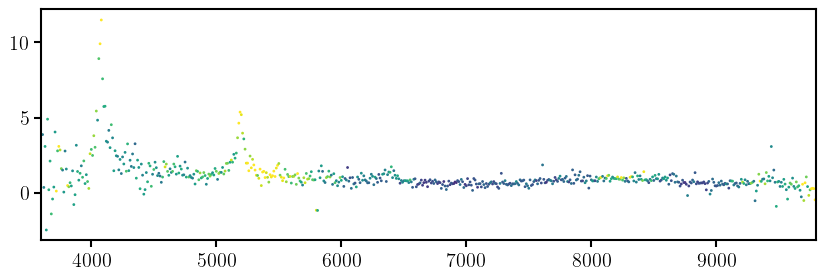

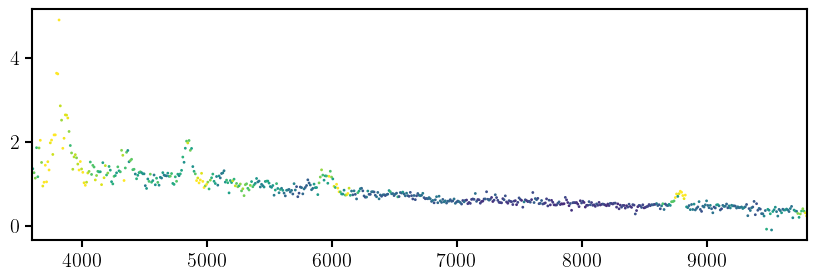

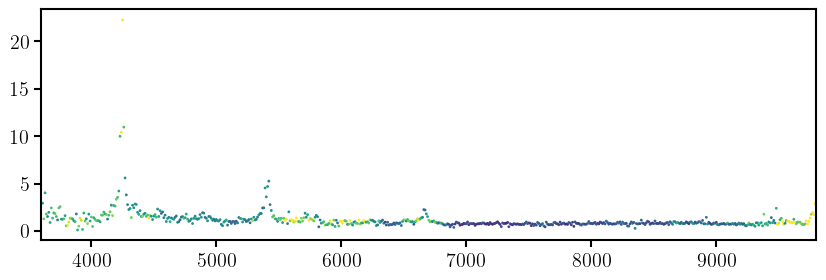

In [46]:
wave_rebin = np.arange(models[0].wave_obs[0], models[0].wave_obs[-1], 10)[1:-1]


for igal in range(10): 
    
    fig = plt.figure(figsize=(10,3))
    sub = fig.add_subplot(111)
    
    sals = []
    for i in range(10): 
        # Compute Guided Backpropagation saliency map
        guided_bp = GuidedBackprop(models[0])
        sal = guided_bp.compute_saliency(spec[igal][None,:], i)
        # Clean up hooks
        guided_bp.remove_hooks()
        sals.append(sal.detach().numpy())
        
    spec_rebin = U.trapz_rebin(np.array(models[0].wave_obs), np.array(spec[igal]), xnew=wave_rebin)
    sal_rebin = U.trapz_rebin(np.array(models[0].wave_obs), np.array(np.mean(sals, axis=0))[0], xnew=wave_rebin)
        
    sub.scatter(wave_rebin, spec_rebin, c=sal_rebin, s=1, vmin=0, vmax=np.quantile(sal_rebin, 0.95))
    sub.set_xlim(3.6e3, 9.8e3)
    plt.show()
